# Detekcja naczyń dna oka z użyciem technik uczenia maszynowego

### Wprowadzenie

Najpierw dokonajmy odpowiednich importów. Biblioteki `opencv` oraz `skimage` posłużą do przetwarzania obrazów. Z użyciem `sklearn` dokonamy klasyfikacji wykorzystując do tego las losowy oraz wyznaczymy jakość klasyfikacji. Biblioteka `imblearn` przyda się przy undersamplingu, `joblib` do efektywnego zapisu do pliku, `os` do wczytywania obrazów z folderu, a `numpy` do działań na obrazach. Biblioteki `pandas` oraz `matplotlib` posłużą jedynie do wizualizacji wyników.

In [49]:
import cv2 as cv
from skimage.util.shape import view_as_windows

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from imblearn.metrics import sensitivity_specificity_support, geometric_mean_score
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump, load
import os
import numpy as np

import pandas
import matplotlib.pyplot as plt

from typing import List, Tuple

Rozpoczniemy od zdefiniowania przydatnych stałych.

In [50]:
OUTPUT_DIR = 'output/'
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'
WINDOW_SIZE = (5, 5)
STEP = 4
PREDICTED_STEP = 1
SHAPE = (584, 876)

Stałe `OUTPUT_DIR`, `TRAIN_DIR`, `TEST_DIR` oznaczają ścieżki do folderów, w których znajdują się kolejno: obrazy generowane przez skrypt, obrazy należące do zbioru treningowego, obrazy testowe. `WINDOW_SIZE` oznacza rozmiar okna przekazywany do funkcji `views_as_windows()`. `STEP` oraz `PREDICTED_STEP` oznaczają krok przekazywany do funkcji `views_as_windows()` odpowiednio dla obrazów ze zbioru treningowego i testowego. `SHAPE` określa rozmiar do jakiego zmniejszone zostaną wszystkie wczytywane obrazy.

In [51]:
def split_image(img: np.ndarray, size: Tuple[int, int], step: int) -> np.ndarray:
    if size[0] % 2 == 0 or size[1] % 2 == 0:
        raise Exception('Must be odd!')
    if len(img.shape) == 3:  # RGB
        return view_as_windows(img, (size[0], size[1], 3), step=step)
    else:  # Grayscale
        return view_as_windows(img, (size[0], size[1]), step=step)

Funkcja `split_image()` dzieli obraz na nachodzące na siebie okna z rozmiarem `size[0] x size[1]` dla obrazów w skali szarości oraz `size[0] x size[1] x 3` dla obrazów RGB. Ponadto wykonuje to z pewnym krokiem `step` - w naszym przypadku krok ten wynosi 4 (`STEP`) dla obrazów ze zbioru treningowego oraz 1 dla obrazów ze zbioru testowego `PREDICTED_STEP`. W związku z tym, że dla każdego okna sprawdzamy czy środkowy piksel zawiera naczynia (jest biały) należy zapewnić także nieparzystość wymiarów.

In [52]:
def extract_features(chunk: np.ndarray) -> np.ndarray:
    rgb_mean = np.mean(chunk, axis=(0, 1))
    rgb_std = np.std(chunk, axis=(0, 1))

    chunk_gray = cv.cvtColor(chunk, cv.COLOR_BGR2GRAY)
    moments = list(cv.moments(chunk_gray).values())

    features = np.concatenate((rgb_mean, rgb_std, moments))
    return features

Funkcja `extract_features()` dla każdego niewielkiego fragmentu zdjęcia (w naszym przypadku okna 5x5) zwraca jednowymiarową listę zawierającą cechy wycinka. Zdecydowano się na średnią każdej składowej RGB, odchylenie standardowe każdej składowej RGB oraz momenty. Łącznie daje to 30 cech dla każdego okna.  

In [53]:
def get_data(img: np.ndarray, step: int) -> Tuple[List, Tuple[int, int]]:
    splitted = split_image(img, WINDOW_SIZE, step)

    data = [extract_features(splitted[i, j, 0])
            for i, j in np.ndindex(splitted.shape[:2])]

    return data

Funkcja `get_data()` dla przekazanego obrazu zwraca dwuwymiarową listę o wielkości `liczba okien x liczba cech okna` zawierającą cechy każdego okna.  

In [54]:
def get_labels(img: np.ndarray, step: int) -> List:
    splitted = split_image(img, WINDOW_SIZE, step)

    labels = []

    for i, j in np.ndindex(splitted.shape[:2]):
        center = (splitted[i, j].shape[0] // 2, splitted[i, j].shape[1] // 2)
        if splitted[i, j, center[0], center[1]] == 0:
            labels.append(0)
        else:
            labels.append(255)

    return labels

Funkcja `get_labels()` dla przekazanego obrazu zwraca listę jednowymiarową o długości równej liczbie okien. Lista ta zawiera etykiety 255 albo 0 oznaczające obecność/brak naczynia w środkowym pikselu okna.

In [55]:
def get_data_set(dir, step) -> Tuple[np.ndarray, np.ndarray]:
    images = sorted(os.listdir(dir), key=lambda x: x.lower())
    img = images[::2]
    truth = images[1::2]

    data_arr = []
    labels_arr = []

    for i in img:
        img_file = cv.imread(dir + str(i))
        scaled = cv.resize(img_file, SHAPE[::-1], cv.INTER_AREA)
        data = get_data(scaled, step=step)
        data_arr.append(data)

    for t in truth:
        img_file = cv.imread(dir + str(t), cv.IMREAD_GRAYSCALE)
        scaled = cv.resize(img_file, SHAPE[::-1], cv.INTER_AREA)
        _, thresh = cv.threshold(scaled, 0, 255, cv.THRESH_BINARY)
        labels = get_labels(thresh, step=step)
        labels_arr.append(labels)

    return np.concatenate(data_arr), np.array(labels_arr).flatten()

Funkcja `get_data_set()` służy do wczytania obrazów zbioru treningowego z folderu `dir`. W naszym przypadku wykorzystano 8 obrazów (`06_h`, `09_dr`, `10_g`, `11_h`, `12_dr`, `12_g`, `12_h`, `14_dr`). Obrazy te są wraz ze swoimi maskami eksperckimi wczytywane, zmniejszane, a w przypadku maski eksperckiej także binaryzowane. Następne dla obrazów naczyń wydobywane są cechy, a dla masek eksperckich - etykiety z odpowiedzią o obecności/braku naczynia. 

In [56]:
def make_model(x, y, from_file=False):

    undersampler = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
    x, y = undersampler.fit_resample(x, y)

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=0)

    if not from_file:
        model = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=700, min_samples_split=2,
                                       min_samples_leaf=20, max_features='sqrt', max_depth=150, bootstrap=False)

        n_estimators = [int(x)
                        for x in np.linspace(start=50, stop=2000, num=10)]
        max_features = ['sqrt', 'log2', None]
        max_depth = [int(x) for x in np.linspace(5, 200, num=10)]
        max_depth.append(None)
        min_samples_split = [1, 2, 4, 6, 8, 10, 15]
        min_samples_leaf = [1, 2, 3, 4, 5]
        bootstrap = [True, False]

        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}

        model = RandomizedSearchCV(
            estimator=model, param_distributions=random_grid, n_iter=55, cv=5, random_state=0, n_jobs=-1, verbose=1)
        model.fit(x_train, y_train)
        dump(model, 'model.joblib')
    else:
        model = load('model.joblib')

    print(f'Score: {round(model.score(x_test, y_test), 3)}')

    return model

Funkcja `make_model()` tworzy nowy model bądź wczytuje istniejący z pliku. Dane przekazane do funkcji są poddane undersamplingowi (0.5 / 0.5), a następnie dzielone na zbiór treningowy i walidacyjny (0.2 / 0.8). Następnie dane treningowe są przekazywane do klasyfikatora `random_forest`, a z użyciem `RandomizedSearchCV` następuje wybór hiperparametrów. Na końcu następuje ocena modelu z użyciem `model.score()`  

In [57]:
train_data, train_labels = get_data_set(dir=TRAIN_DIR, step=STEP)
model = make_model(train_data, train_labels, from_file=True)

Score: 0.874


Najlepsze osiągnięte accuracy wyniosło 0.874

In [58]:
def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv.connectedComponentsWithStats(
        image, connectivity=8)

    sizes = stats[1:, -1]
    width = stats[1:, -3]
    height = stats[1:, -2]
    components -= 1

    result = np.zeros((output.shape))

    for i in range(0, components):
        if sizes[i] >= min_size and (width[i] > 10 or height[i] > 10):
            result[output == i + 1] = 255

    return result

Funkcja `remove_small_elements()` jest elementem post-processingu i służy "odszumieniu" wynikowej maski, która zawiera wiele białych pikseli - tła niepoprawnie sklasyfikowanego jako naczynia.

In [59]:
def process(path: str) -> np.ndarray:
    img = cv.imread(TEST_DIR + path)
    scaled = cv.resize(img, SHAPE[::-1], cv.INTER_AREA)
    data = get_data(scaled, PREDICTED_STEP)
    labels = model.predict(data)

    recovered = np.zeros(SHAPE, dtype=np.uint8)
    chunk_shape = split_image(recovered, WINDOW_SIZE, PREDICTED_STEP).shape
    counter = 0
    for x in range(chunk_shape[0]):
        for y in range(chunk_shape[1]):
            x1, y1 = x * PREDICTED_STEP, y * PREDICTED_STEP
            x2, y2 = x1 + WINDOW_SIZE[0], y1 + WINDOW_SIZE[1]
            recovered[(x1 + x2) // 2, (y1 + y2) // 2] = 255 if labels[counter] == 255 else 0
            counter += 1
    
    recovered = remove_small_elements(recovered, 20)
    return recovered
    

Funkcja `process()` dla zadanej ścieżki do obrazu z naczyniami generuje maskę z użyciem wyżej opisanego modelu.

In [60]:
def process_mask(path: str) -> np.ndarray:
    img = cv.imread(TEST_DIR + path, cv.IMREAD_GRAYSCALE)
    scaled = cv.resize(img, SHAPE[::-1], cv.INTER_AREA)
    _, thresh = cv.threshold(scaled, 0, 255, cv.THRESH_BINARY)
    return thresh

Funkcja `process_mask()` dla zadanej ścieżki wczytuje maskę ekspercką, zmniejsza i binaryzuje.

In [61]:
# Helper function
def is_binary(image: np.ndarray) -> bool:
    return ((image == 0) | (image == 255)).all()

def compare(image: np.ndarray, truth: np.ndarray) -> dict:
    if not is_binary(image):
        raise Exception('Image is not binary (0 or 255)')
    
    if not is_binary(truth):
        raise Exception('Ground truth is not binary (0 or 255')

    image = image.flatten()
    truth = truth.flatten()

    report = classification_report(truth, image, output_dict=True)

    accuracy = round(accuracy_score(truth, image), 2)
    sensivity = round(report['255']['recall'], 2)
    specifity = round(report['0']['recall'], 2)

    weighted_result = sensitivity_specificity_support(
        truth, image, average='weighted')

    weight_sensivity = round(weighted_result[0], 2)
    weight_specifity = round(weighted_result[1], 2)
    matrix = confusion_matrix(truth, image)
    geometric_mean = round(geometric_mean_score(truth, image),2)

    return {
        'accuracy': accuracy,
        'sensivity': sensivity,
        'specifity': specifity,
        'wgt_sens': weight_sensivity,
        'wgt_spec': weight_specifity,
        'geo_mean': geometric_mean,
        'matrix': str(matrix.flatten())
    }

Funkcja `compare()` wyznacza kolejno miary jakości klasyfikacji: `accuracy`, `sensivity`, `specifity`, `weighted sensivity`, `weighted specifity`, `geometric mean`, `confusion matrix`.

In [62]:
def visualise(image: np.ndarray, truth: np.ndarray) -> np.ndarray:
    predicted_vessels = (image == 255)
    true_vessels = (truth  == 255)

    predicted_correct = (predicted_vessels & true_vessels)

    green_predicted = np.zeros((*truth.shape, 3), dtype=np.uint8)
    green_predicted[true_vessels, :] = 255

    green_predicted[predicted_correct] = [0, 255, 0]

    return green_predicted

Funkcja `visualise()` służy wizualizacji wyniku poprzez naniesienie trafnie sklasyfikowanych naczyń kolorem zielonym na maskę ekspercką.

### Analiza jakości podejścia

In [63]:
def analyse():
    images = sorted(os.listdir(TEST_DIR), key=lambda x: x.lower())

    if not os.path.isdir(TEST_DIR):
        os.mkdir(TEST_DIR)
        print(f'"{TEST_DIR}" directory has been created.')

    if len(images) % 2 != 0:
        raise Exception("len(images) != len(ground_trouth)")
    
    # Assumes that we have only .jpg (img) and .tif (truth) images!
    img = images[::2]
    truth = images[1::2]
    examples = [{'name': i, 'img': i, 'truth': t, 'comparison': None, 'visualisation': None} 
                for i,t in zip(img,truth)]

    for example in examples:
        example['img'] = process(example['img'])
        example['truth'] = process_mask(example['truth'])
        example['comparison'] = compare(example['img'], example['truth'])
        example['visualisation'] = visualise(example['img'], example['truth'])
        cv.imwrite(OUTPUT_DIR + example['name'][:-4] + ".jpg", example['img'])
        cv.imwrite(OUTPUT_DIR + example['name'][:-4] + "_w.jpg", example['visualisation'])

    fig, axs = plt.subplots(len(examples), 3, sharex=True, sharey=True)
    fig.set_figwidth(20)
    fig.set_figheight(6 * len(examples))

    # Workaround for 1 image
    axs = np.array([axs]) if len(examples) == 1 else axs
  
    for i, example in enumerate(examples):
        axs[i, 0].set_title('Maska ekspercka', {'fontsize': 18})
        axs[i, 0].axis('off')
        axs[i, 0].imshow(example['truth'], cmap='gray')

        axs[i, 1].set_title('Przetworzony ' + example['name'], {'fontsize': 18})
        axs[i, 1].axis('off')
        axs[i, 1].imshow(example['img'], cmap='gray')
        
        axs[i, 2].set_title('Wizualizacja', {'fontsize': 18})
        axs[i, 2].axis('off')
        axs[i, 2].imshow(example['visualisation'], cmap='gray')
    
    plt.tight_layout()

    index = [example['name'] for example in examples]
    matrix = [example['comparison'].pop('matrix', None) for example in examples]
    comparison = [example['comparison'] for example in examples]
   
    print(pandas.DataFrame(comparison, index=index))
    print('------------------------------------------------------------------')
    print(pandas.DataFrame(matrix, index=index, columns=['confusion_matrix']))

           accuracy  sensivity  specifity  wgt_sens  wgt_spec  geo_mean
01_dr.JPG      0.90       0.80       0.91      0.90      0.80      0.85
01_g.jpg       0.90       0.75       0.91      0.90      0.76      0.83
01_h.jpg       0.89       0.82       0.90      0.89      0.83      0.85
02_dr.JPG      0.88       0.77       0.89      0.88      0.78      0.83
02_g.jpg       0.89       0.75       0.90      0.89      0.77      0.82
02_h.jpg       0.88       0.90       0.88      0.88      0.90      0.89
------------------------------------------------------------------
                        confusion_matrix
01_dr.JPG  [438430  42589   6206  24359]
01_g.jpg   [431395  40080  10133  29976]
01_h.jpg   [405752  47452  10735  47645]
02_dr.JPG  [422275  51286   8710  29313]
02_g.jpg   [421843  45298  11000  33443]
02_h.jpg   [398622  56708   5706  50548]


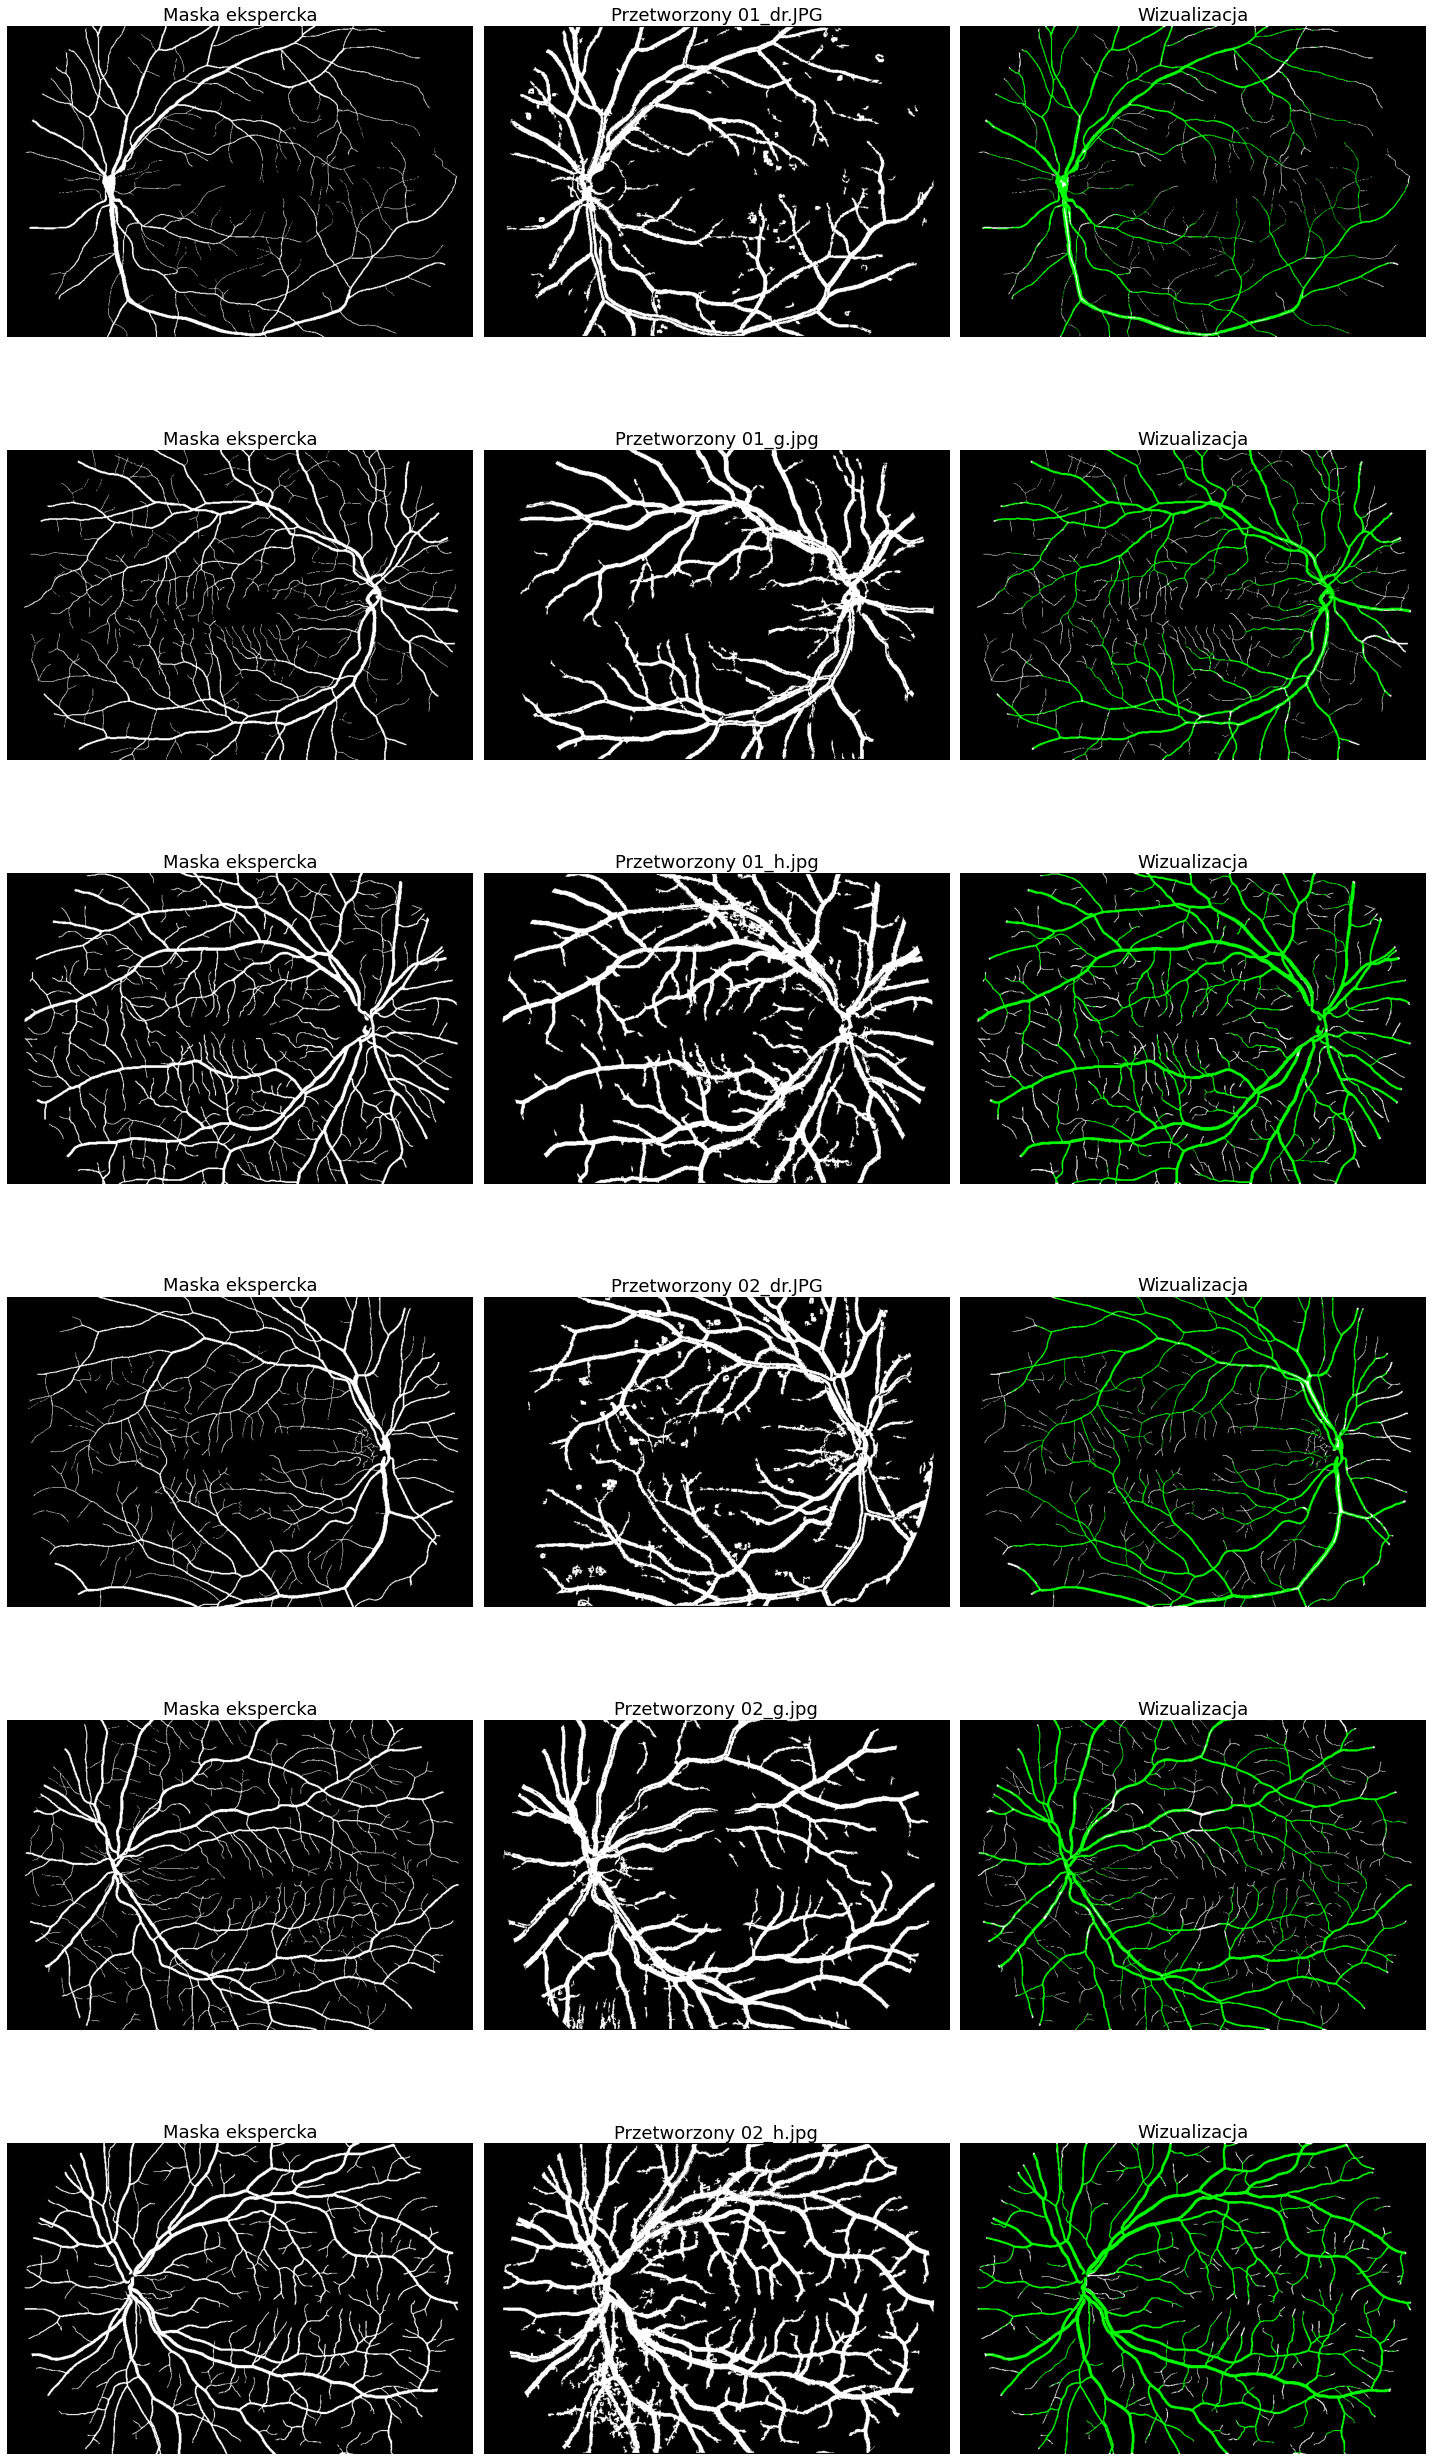

In [65]:
analyse()

### Podsumowanie
Rezultaty osiągnięte techniką uczenia maszynowego są w ogólności gorsze od rezultatów osiągniętych przez techniki przetwarzania obrazu. Istotną trudnością przy uczeniu maszynowym był wybór cech, który pozwoliłby na odróżnienie naczyń od tła, wybór odpowiedniego klasyfikatora i dobór jego hiperparametrów, a także konieczność przekazywania dużych zbiorów danych zużywających zasoby komputera i wymagających czasu.  